# DSCI 100: Group 20 Project Report

**Date**: *Aug 14th, 2021*

**Authors**: *Thomas Cowan, Marcela Flaherty, Tony Liang, Hamidreza Yarveicy*

### Import necessary packages

In [22]:
# httr, ggplot2, and GGally were all available without installation on the DSCI 100 Jupyter Hub, but if errors occur, please install these packages.
library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(GGally)
library(gridExtra)


## Introduction

Pulsars are a type of dense, highly magnetized star that emits periodic radio bursts from its rotational poles$^{[1]}$. Limited research has been conducted on the detection of pulsars with the use of data science methods. We will attempt to answer the following question: 

> Can pulsar radio emissions be accurately differentiated from radio frequency interference (RFI) and radio noise?

To address this question properly, we will investigate a collection of radio emissions recorded during the [High Time Resolution Universe Pulsar Survey](https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip)$^{[2]}$ (HTRU2). It contains 16,259 examples caused by RFI/noise and 1,639 real pulsars.

The HTRU2 data set contains statistics on signal-to-noise ratios (SNR) and integrated profiles (a method of stacking multiple measurements of the same pulsar) of areas of The Southern Hemisphere. 

![image](https://i.imgur.com/JpWpvRr.gif)

![image](https://i.imgur.com/JLhFw1A.gif)


[Joeri van Leeuwen. License: CC-BY-AS](https://www.astron.nl/pulsars/animations/)

[Essentials of Radio Astronomy](https://www.cv.nrao.edu/~sransom/web/Ch6.html)

**Fig. 1** An artist's animation (top) of a radio profile from a pulsar, and a series of these profiles from a single star integrated together (bottom).

## Methods and Results

#### Download Pulsar Data

In [2]:
# Download zipped Pulsar data from PULSAR_URL
PULSAR_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(PULSAR_URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it, renaming the columns as below
# then mutate the target class to a meaningful value for a human and convert to a factor
pulsar_data_raw <- read_csv(unz(tf, "HTRU_2.csv"), col_names = c("mean_ip", 
                                                             "std_ip", 
                                                             "excess_kurtosis_ip", 
                                                             "skewness_ip", 
                                                             "mean_dm_snr", 
                                                             "std_dm_snr", 
                                                             "excess_kurtosis_dm_snr", 
                                                             "skewness_dm_snr", 
                                                             "target_class")) %>% 
                 mutate(target_class = as_factor(case_when(
                                                target_class == 1 ~ "pulsar",
                                                TRUE ~ "rfi_noise")))  
# unlink/remove the temporary file
unlink(tf)

# preview the data
pulsar_data_raw %>% head(5)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2021-08-14 13:13
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/RtmpXWbeHo/file5f8bd8174.zipNULL

Parsed with column specification:
cols(
  mean_ip = col_double(),
  std_ip = col_double(),
  excess_kurtosis_ip = col_double(),
  skewness_ip = col_double(),
  mean_dm_snr = col_double(),
  std_dm_snr = col_double(),
  excess_kurtosis_dm_snr = col_double(),
  skewness_dm_snr = col_double(),
  target_class = col_double()
)



mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rfi_noise
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rfi_noise
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rfi_noise
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise


### Data Summary and Recipe Construction
The pulsar data is tidy, but it suffers from a large class imbalance: only ~9% of our dataset is classified as a true pulsar. This can be a significant source of error in a final KNN model if it is not addressed in the training data processing. Below we will:
- Split our data into 50% training and 50% testing
- Create a recipe which will upsample our training data to better balance the class distribution
- Plot the old and new class numbers next to each other to highlight the effect of this upsampling in terms of class labels

We believe our 50/50 train/test split is a good compromise between model speed and accuracy. We saw severe training slowdowns for training splits above 50% which is expected for KNN models with large underlying training sets and many potential predictors. 

In [3]:
set.seed(1) # set the random seed so that sample_frac selects the same rows each run
pulsar_split <- initial_split(pulsar_data_raw, prop = 0.5, strata = target_class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


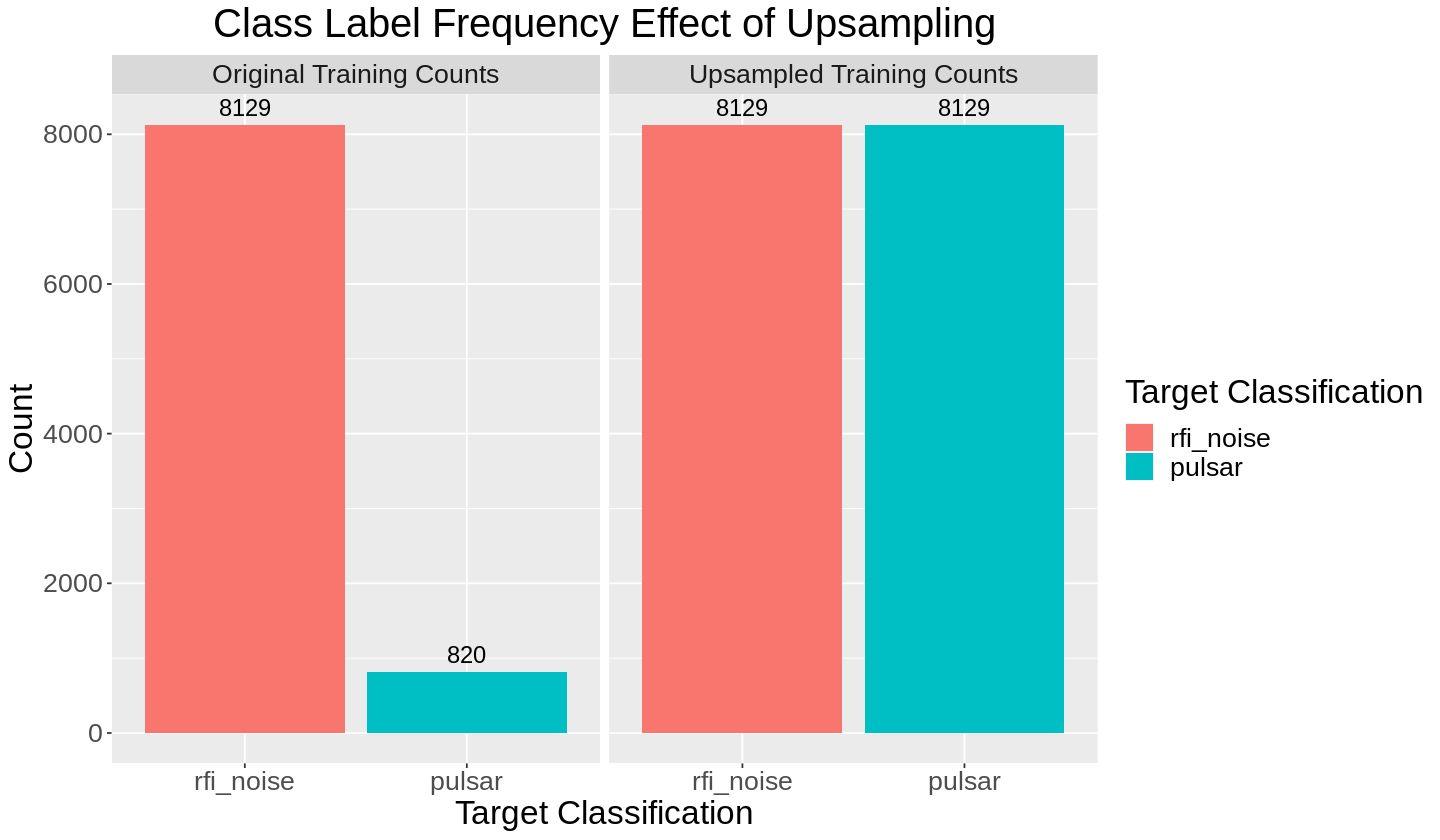

In [4]:
options(repr.plot.width = 12, repr.plot.height = 7)

# create upsample recipe to combat class imbalance in the original data set
pulsar_upsample_recipe <- recipe(target_class ~ ., data = pulsar_train) %>% 
                    step_center(all_predictors()) %>% 
                    step_scale(all_predictors()) %>% 
                    step_upsample(target_class, over_ratio = 1, skip=FALSE) # skip = FALSE here only for display purposes

pulsar_train_prepped <- pulsar_upsample_recipe %>% 
                    prep() %>% 
                    bake(pulsar_train)

# merge original and upsampled data for side-by-side plotting purposes
join_by = c("mean_ip", "std_ip", "excess_kurtosis_ip",
            "skewness_ip", "mean_dm_snr", "std_dm_snr", 
            "excess_kurtosis_dm_snr", "skewness_dm_snr", 
            "target_class", "is_prepped")

pulsar_train_prepped_merge <- full_join(pulsar_train %>% mutate(is_prepped = FALSE),
                                        pulsar_train_prepped %>% mutate(is_prepped = TRUE),
                                        by = join_by)



upsample_compare_bar_plot <- pulsar_train_prepped_merge %>% 
                        ggplot(aes(x = target_class, fill = target_class)) + 
                            geom_bar() +
                            labs(x = "Target Classification", 
                                 y = "Count",
                                 fill = "Target Classification") +
                            geom_text(stat='count', aes(label=..count..), vjust = -0.5, size=5) +
                            ggtitle("Class Label Frequency Effect of Upsampling") +
                            theme(text = element_text(size=20),
                                  plot.title = element_text(hjust = 0.5)) +
                        facet_wrap(~ is_prepped,
                                   labeller = labeller(is_prepped = c("TRUE" = "Upsampled Training Counts", 
                                                                      "FALSE" = "Original Training Counts")))
upsample_compare_bar_plot

**Fig. 2** After upsampling with a target ratio of 1:1 we can see that 7,399 new pulsar points have been generated and the class labels are balanced.

#### Summary stats of the unscaled pulsar data
The following table summarizes the max, min, mean, variance, standard deviation, and number of NaNs for each variable for the unscaled pulsar data.

In [5]:
min_df <- pulsar_train %>% 
            select(-target_class) %>% 
            map_df(min)
max_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(max)
mean_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(mean)
sd_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(sd)
var_df <- pulsar_train %>%
            select(-target_class) %>% 
            map_df(var)
count_nan_df <- pulsar_train %>% 
                select(-target_class) %>% 
                map_df(~sum(is.na(.)))

# get a vector of all the columns to join by
join_cols = colnames(pulsar_train %>% select(-target_class))

# join the stats tables together
stats_table <- full_join(min_df, max_df, by=join_cols) %>% 
                full_join(., mean_df, by=join_cols) %>% 
                    full_join(., var_df, by=join_cols) %>% 
                        full_join(., sd_df, by=join_cols) %>%
                            full_join(., count_nan_df, by=join_cols) %>%
                mutate(stat_type = c("min", "max", "mean", "var", "st_dev", "nan_count")) %>% 
                mutate(stat_type = as_factor(stat_type)) %>% 
                relocate(stat_type) 

print("Unscaled Training Data Statistics Summary")
stats_table

[1] "Unscaled Training Data Statistics Summary"


stat_type,mean_ip,std_ip,excess_kurtosis_ip,skewness_ip,mean_dm_snr,std_dm_snr,excess_kurtosis_dm_snr,skewness_dm_snr
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
min,6.179688,24.791612,-1.8760112,-1.781888,0.2132107,7.370432,-3.139270,-1.964998
max,192.617188,98.778911,8.0695220,68.101622,223.3921405,107.947490,34.539844,1191.000837
mean,110.967121,46.506850,0.4775022,1.760162,12.7007876,26.289515,8.315404,105.369053
var,656.664374,47.182994,1.1199679,37.211915,885.3437651,375.850249,20.653044,11927.734346
st_dev,25.625463,6.868988,1.0582853,6.100157,29.7547268,19.386858,4.544562,109.214167
nan_count,0.000000,0.000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000


**Fig. 3:** The above table shows that we have no `NaN` entries. The min/max/and variance of each variable are different enough to suggest that scaling and centering our data will be beneficial to our model's performance.

#### Exploratory Plotting
The pair plot (Fig. 4) below shows the distributions and relationships between all the variables in the data set, colored by `target_class`. Visually there appears to be good class separation for integrated profile statisitics (those postfixed with `_ip`) and moderate to poor class separation for the signal to noise statistics (those postfixed with `_dm_snr`). The kernel density estimates also show fairly good class label distribution separation within all the variables.

For the final predictor selection, we will use forward selection as described in section 6.6.3 of the textbook$^{[3]}$.

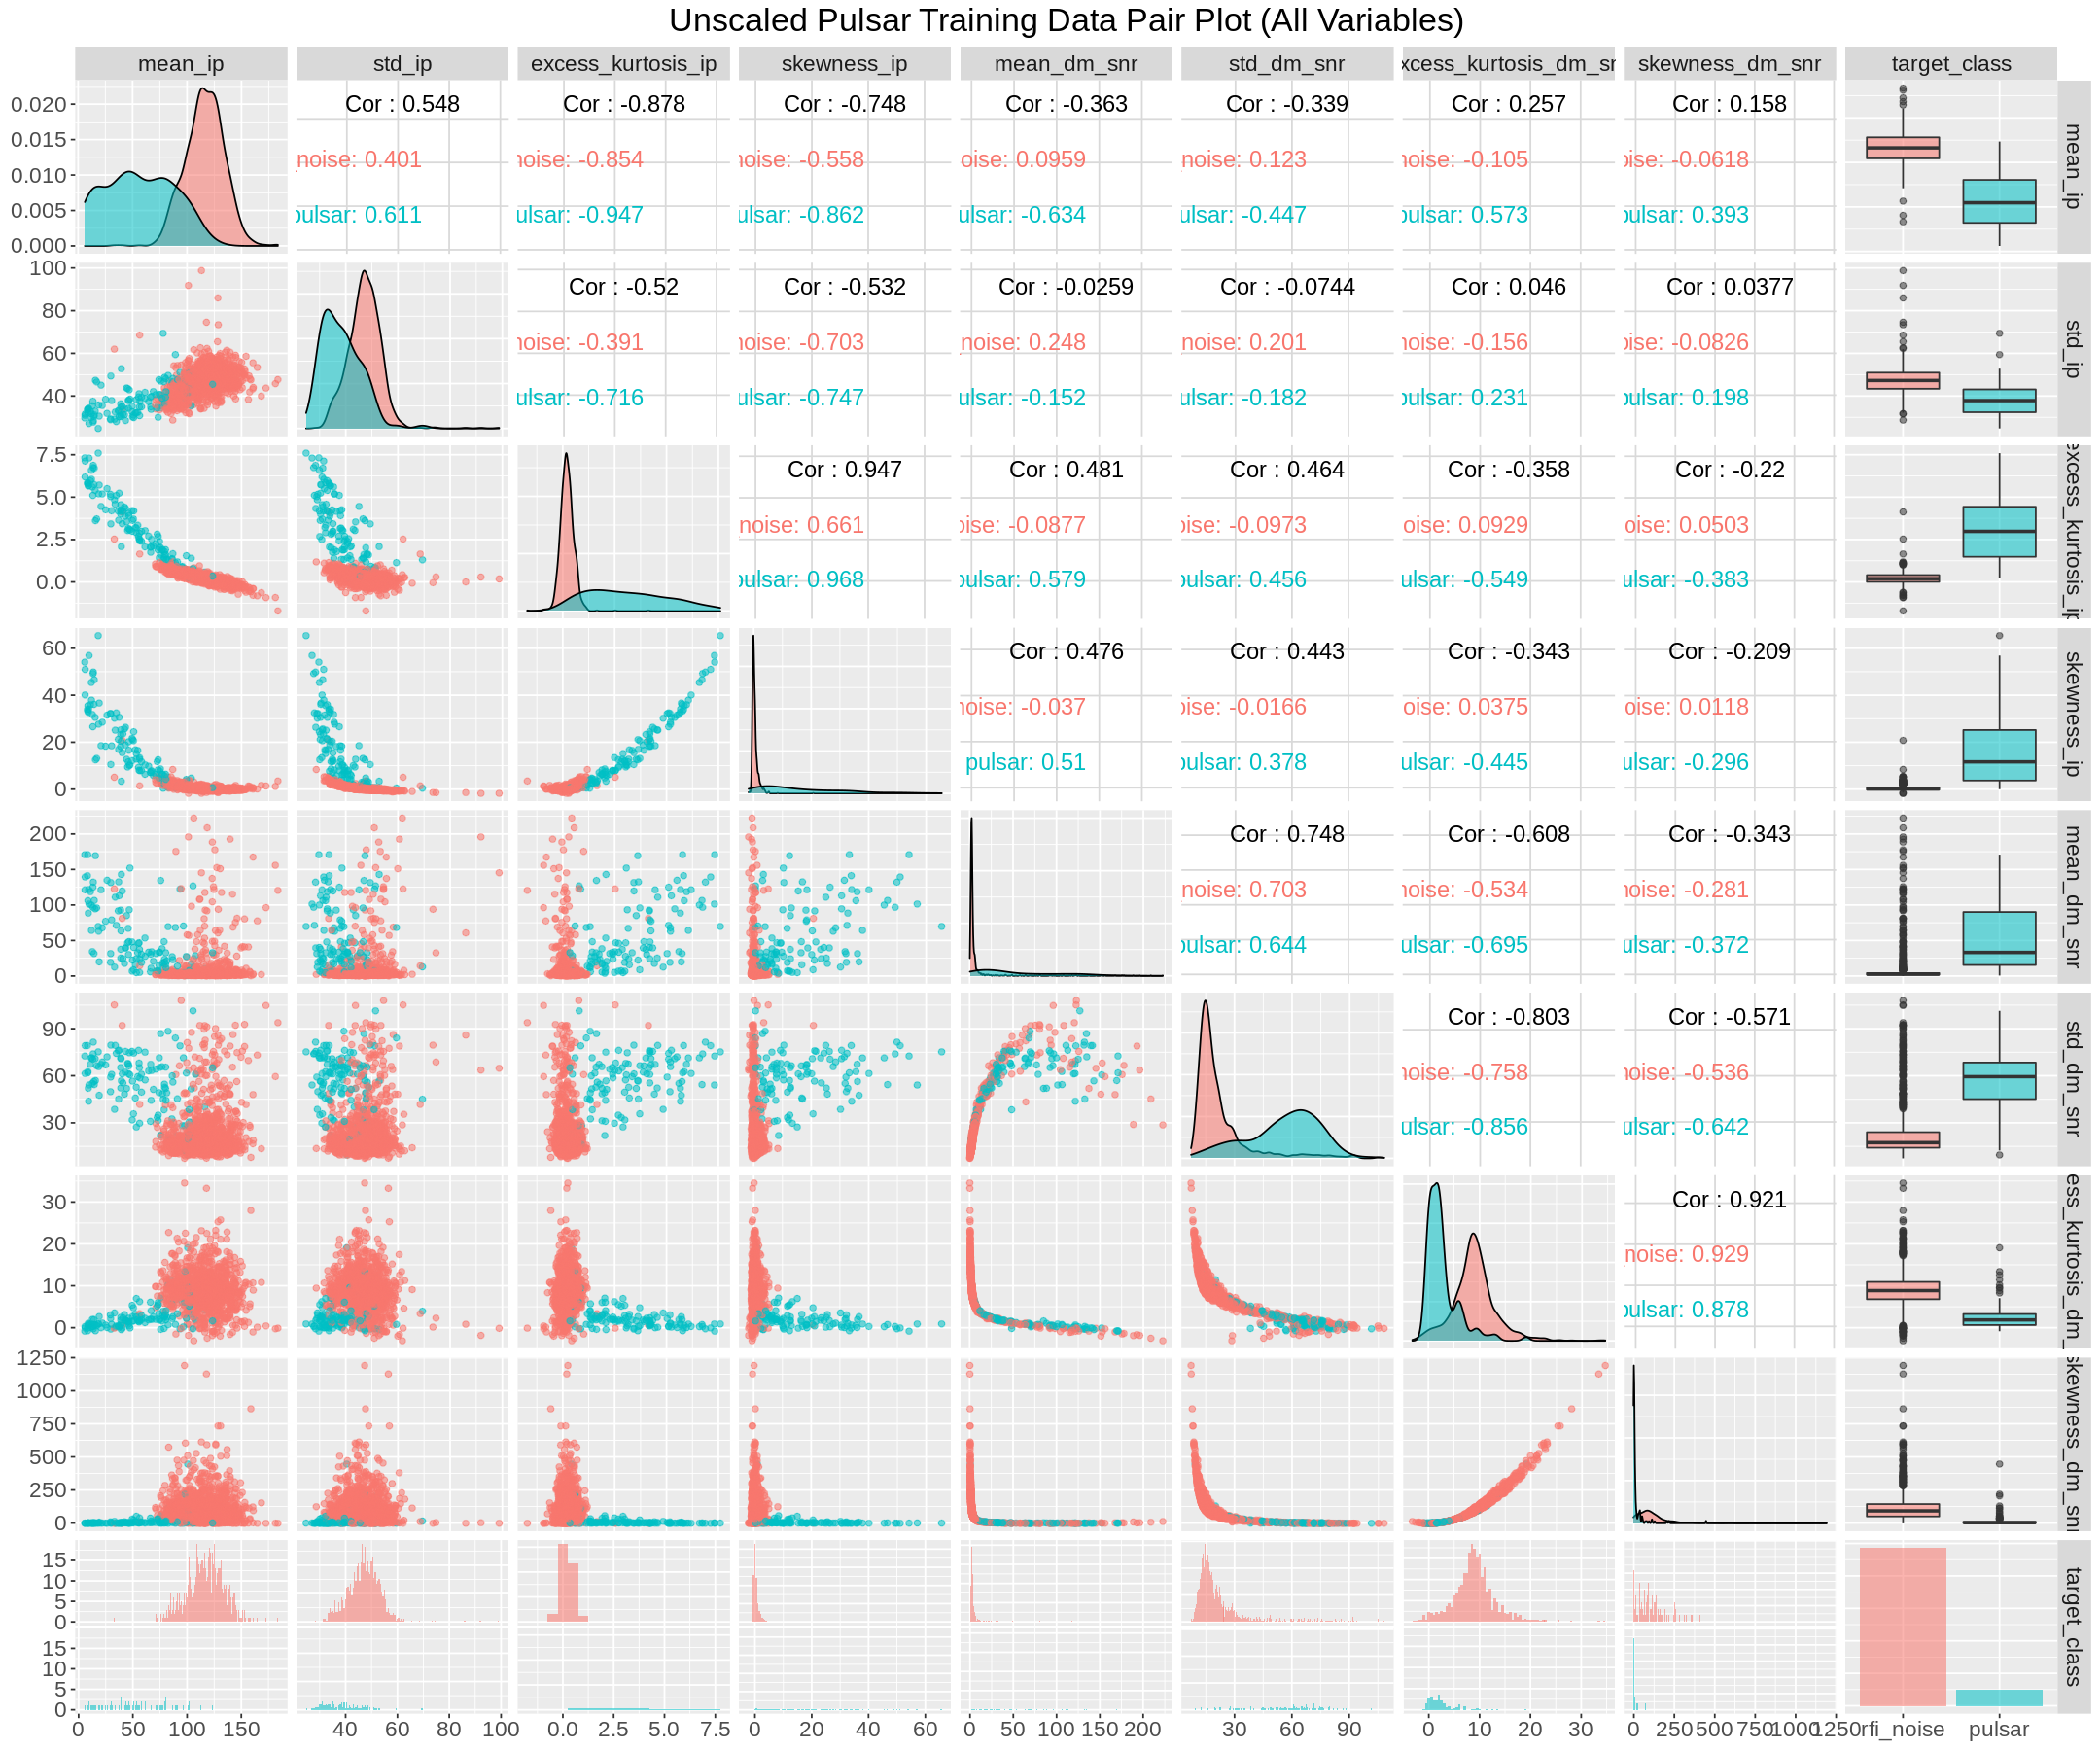

In [7]:
options(repr.plot.width = 18, repr.plot.height = 15)

# subset of the data for faster plotting
pulsar_scaled_subset <- pulsar_train %>% sample_frac(0.15) 

ggpairs(pulsar_scaled_subset,
           mapping = aes(color=target_class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.5)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Unscaled Pulsar Training Data Pair Plot (All Variables)") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.5))
        

**Fig. 4** A pair plot of unscaled pulsar training data. The displayed data is a random subset (15%) of the training data to improve plot readability and performance.

### Forward Selection of Predictors

We will use the scaled and upsampled training data for predictor selection. The results show that peak estimated accuracy is achieved using either `excess_kurtosis_ip, mean_dm_snr, std_ip, mean_ip`, or `excess_kurtosis_ip, mean_dm_snr, std_ip, mean_ip, skewness_ip`.

This block takes more than 10 minutes to run on the UBC servers.

In [19]:
# Workflow adapted from 6.6.3 in the DSCI 100 textbook

set.seed(1) # reset the seed so that this cell produces the same results no matter what order it is run in

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), model_string = character(), accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-valication object
pulsar_vfold <- vfold_cv(pulsar_train, v = 5 , strata = target_class)

# store the total number of predictors
names = colnames(pulsar_train %>% select(-target_class))
n_total <- length(names)

# create a vector to store selected predictors
selected <- c()

# for each predictor
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("target_class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_loop_recipe <- recipe(as.formula(model_string), data = pulsar_train) %>% 
                    step_center(all_predictors()) %>% 
                    step_scale(all_predictors()) %>% 
                    step_upsample(target_class, over_ratio = 1)

        # tune the KNN classifier with these predictors, and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(pulsar_loop_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = pulsar_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% add_row(size = i, model_string = models[[jstar]], accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}


#### Plot of Predictor Estimated Accuracy

size,model_string,accuracy
<int>,<chr>,<dbl>
1,target_class ~ excess_kurtosis_ip,0.9630133
2,target_class ~ excess_kurtosis_ip+mean_dm_snr,0.9669236
3,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip,0.9699406
4,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip,0.9715047
5,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip,0.9715048
6,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip+std_dm_snr,0.9709462
7,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip+std_dm_snr+skewness_dm_snr,0.9710583
8,target_class ~ excess_kurtosis_ip+mean_dm_snr+std_ip+mean_ip+skewness_ip+std_dm_snr+skewness_dm_snr+excess_kurtosis_dm_snr,0.9703879


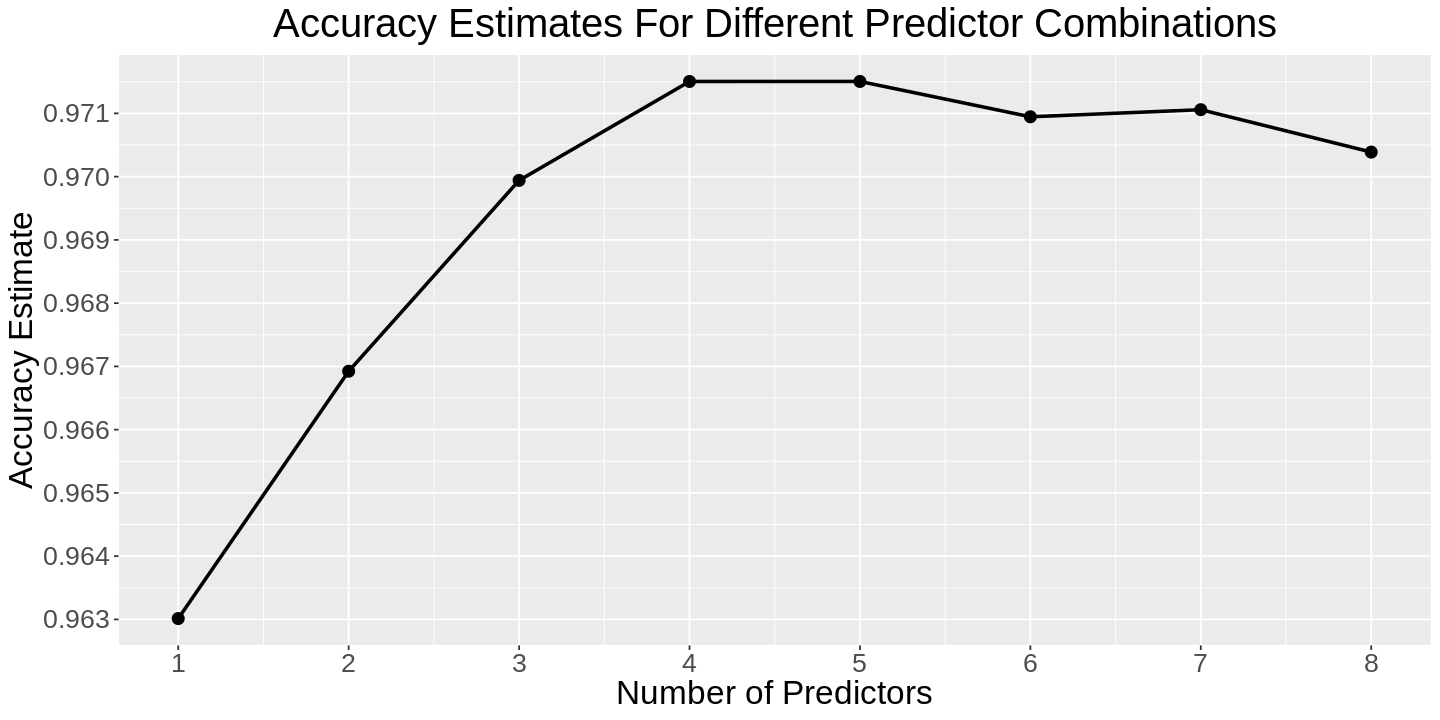

In [38]:
options(repr.plot.width = 12, repr.plot.height = 6)

accuracy_plots_num_predictors <- accuracies %>% 
    ggplot(aes(x = size, y = accuracy)) +
        geom_line(size=1) + geom_point(size=3) + 
        labs(x = "Number of Predictors", y = "Accuracy Estimate") +
        scale_y_continuous("Accuracy Estimate", seq(0.94, 1.0, 0.001)) +
        scale_x_continuous("Number of Predictors", c(1:8)) +
        ggtitle("Accuracy Estimates For Different Predictor Combinations") +
        theme(text = element_text(size=20),
              plot.title = element_text(hjust = 0.5))

accuracy_plots_num_predictors
accuracies

**Fig. 5** Plot of the accuracy estimates for different predictor combinations, showing 4-5 predictors as the maximum estimated accuracy. Accuracy estimates increase until we reach 4 predictors, and decrease slightly starting at 6 predictors.

Figure 5 suggests that our optimum number of predictors is 4.

### Fitting the Model 
Next, we conduct another v-fold cross-validation using our optimum predictors `target_class ~ excess_kurtosis_ip + mean_dm_snr + std_ip + mean_ip` in order to determine the optimum $k$ parameter for our nearest neighbor classification. In order to avoid ties, we evaluate the odd values $k = 1, 3, 5, 7, 9, 11, 13, 15$ since KNN will use a simple majority to select the class label and we have only two classes.

In [6]:
set.seed(1)
#kknn specification with euclidean distance
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) %>%
                set_engine("kknn") %>%
                set_mode("classification")
# set 5 folds 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5 , strata = target_class)

# cross validation to find accuracy of different k neighbors when using specified variables as predictors
optimum_recipe <- recipe(target_class ~ excess_kurtosis_ip + 
                                        mean_dm_snr + std_ip + 
                                        mean_ip, 
                                        data = pulsar_train) %>% 
                        step_center(all_predictors()) %>% 
                        step_scale(all_predictors()) %>% 
                        step_upsample(target_class, over_ratio = 1)

gridvals <- tibble(neighbors = seq(1, 15, by = 2))

knn_results <- workflow() %>%
    add_recipe(optimum_recipe) %>% 
    add_model(knn_spec) %>%
    tune_grid(resamples = pulsar_vfold, grid = gridvals)  %>%
    collect_metrics() 
                  
# filter to the accuracies of each neighbor
accuracy_estimates <- knn_results%>%
              filter(.metric %in% c("accuracy"))
               

Next, we plot the estimated accuracy for different values of $k$.

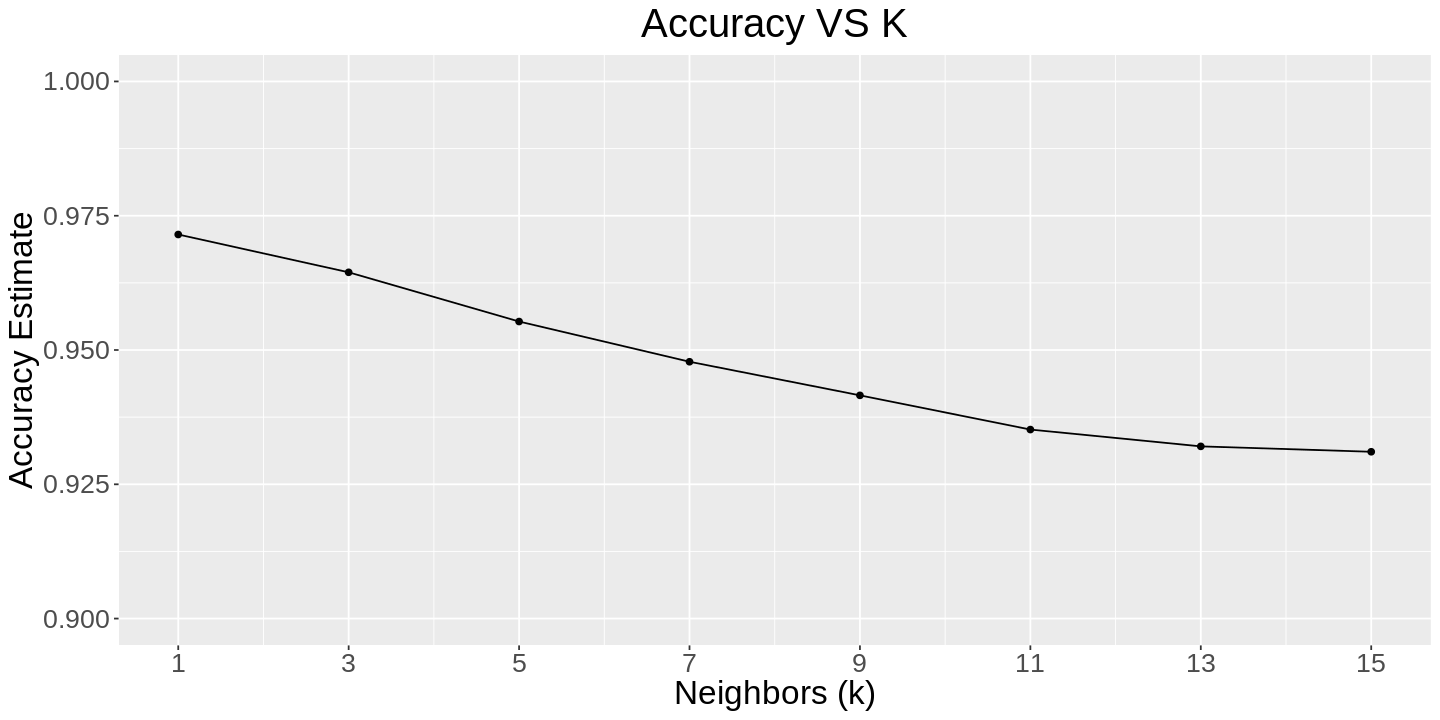

In [7]:
# plot the accuracy of each k neighbors with excluded predictors
options(repr.plot.width = 12, repr.plot.height = 6)
accuracy_versus_k <- ggplot(data = accuracy_estimates, aes (x = neighbors, y = mean)) + 
                         geom_point() + 
                         geom_line() +
                         labs(x = "Neighbors (k)", y = "Accuracy Estimate", title = "Accuracy VS K") + 
                         scale_x_continuous(breaks = seq(1, 15, by = 2)) + 
                         scale_y_continuous(limits = c(0.9 , 1.0)) +
                         theme(text = element_text (size = 20),
                              plot.title = element_text(hjust=0.5))   
accuracy_versus_k


**Fig. 6:** Accuracy estimates for different $k$ values. 

Based on figure 6, we select $k = 3$ as our optimal $k$ as we believe $k = 1$ would overfit the training data. Finally, we train our model using our optimum predictors `excess_kurtosis_ip + mean_dm_snr + std_ip + mean_ip` and optimum $k$ parameter. 

In [19]:
set.seed(1)
# Pulls out the optimal k value for the model
k_best <- accuracy_estimates %>%
          arrange(desc(mean)) %>%
          slice(2) %>%  # select k = 3 as k = 1 will be overfit
          pull(neighbors)  

# Creating new spec based on optimal K
best_spec <- nearest_neighbor(weight_func = "rectangular" , neighbor = k_best) %>%
              set_engine("kknn") %>%
              set_mode("classification")

# Fit the model
pulsar_fit <- workflow() %>%
             add_recipe(optimum_recipe) %>%
             add_model(best_spec) %>%   
             fit(data = pulsar_train)

# Predict the testing data with our fitted model
pulsar_predictions <- predict(pulsar_fit, pulsar_test) %>%
                     bind_cols(pulsar_test)

# Estimate of the truth and our predictive class
pulsar_metrics <- pulsar_predictions %>%
                 metrics(truth = target_class , estimate = .pred_class)

# Confustion matrix of truth and our predictive class
pulsar_conf_mat <- pulsar_predictions %>%
                  conf_mat(truth = target_class, estimate = .pred_class)
print("Pulsar Model Metrics on Testing Data")
pulsar_metrics
print("Pulsar Model Confusion Matrix on Testing Data")
pulsar_conf_mat

[1] "Pulsar Model Metrics on Testing Data"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9641301
kap,binary,0.7947662


[1] "Pulsar Model Confusion Matrix on Testing Data"


           Truth
Prediction  rfi_noise pulsar
  rfi_noise      7923    114
  pulsar          207    705

**Table 1** Model accuracy and kappa on the testing data (top) and the confusion matrix for the testing data prediction results (bottom)

Our model has an accuracy of $96.4\%$ on the testing dataset, largely because `rfi_noise` is ~$91\%$ of our data. Our confusion matrix shows a precision of $\frac{705}{207 + 705} = 0.77$ (or ~$77\%$) and recall of $\frac{705}{114 + 705} = 0.86$ (or ~$86\%$). These values tell us that when our model predicts that a point is a pulsar it is correct $77\%$ of the time, and when a point is truly a pulsar, our model correctly identifies it $86\%$ of the time.

To determine if our model provides improved performance over a model that always classifies a point as `rfi_noise`, known as the "majority classifier", we will calculate the proportion of each class in our testing set.




In [21]:
# caluclate the propotions of each class in the testing data
pulsar_proportions <- pulsar_test %>% 
    group_by(target_class) %>% 
    summarize(count = n()) %>% 
    mutate(percent = round(100*count/nrow(pulsar_test), 2))

pulsar_proportions

`summarise()` ungrouping output (override with `.groups` argument)



target_class,count,percent
<fct>,<int>,<dbl>
rfi_noise,8130,90.85
pulsar,819,9.15


**Table 2** Proportions of each class in the testing data. If we had simply classified every new point as the majority class (rfi_noise) we would expect an accuracy of $90.85\%$

Table 2 shows that we have not improved much in accuracy over the majority classifier ($96.4\%$ vs $90.85\%$) and that our accuracy metric is likely dominated by the correct classification of `rfi_noise`. However, it is encouraging that our model is only miss-classifying pulsars $14\%$ of the time. 

Additionally, any researchers using this model to rapidly screen new data can feel confident that \~$77\%$ of identified pulsars are truly pulsars. In our testing case, this means that instead of manually evaluating $8,949$ pulsar candidates, the scientist only needs to double-check $912$ pulsar candidates, approximately three-quarters of which (\~$705$) will be real pulsars. This reduces the pre-processing and identification workload of astronomers by ~$90\%$, and because the subset generated by our model will be mostly composed of high-quality pulsar examples, it may also increase the quality of observations that can be made about each potential star.

In figure 7 (below) we visualize where these misclassifications are occurring. We can see that a majority of incorrect predictions occur in the area of class overlap. This overlapping zone is important as it is also an area that is difficult for a human to classify visually. While our model performs well in the aggregate, more work (and perhaps a different approach) is needed to fine-tune a model to consistently identify pulsars with these properties.

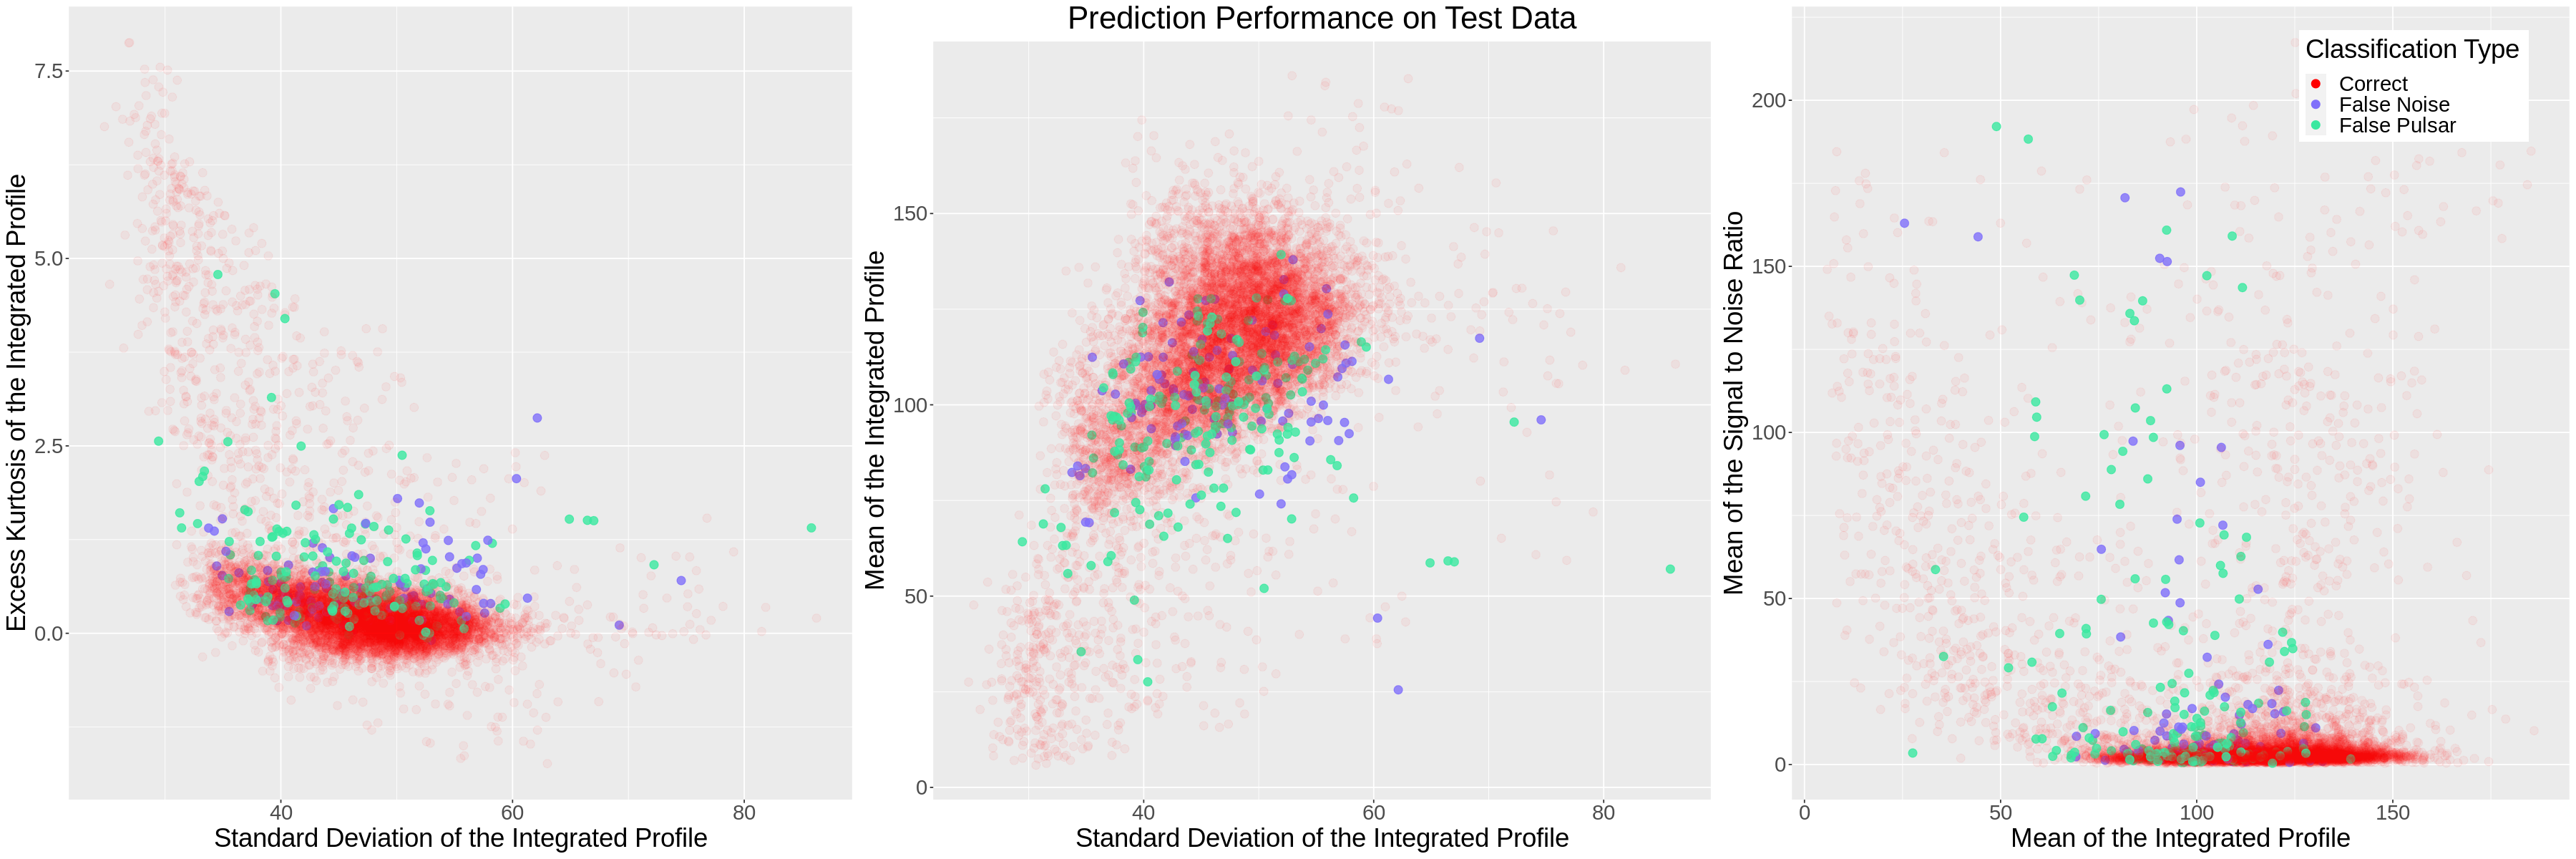

In [64]:
options(repr.plot.width = 30, repr.plot.height = 10)

pulsar_predictions_fp_labels <- pulsar_predictions %>%
    mutate(correct = case_when(
        ((.pred_class != target_class) & (.pred_class == 'pulsar') ~ 'False Pulsar'),
        ((.pred_class != target_class) & (.pred_class == 'rfi_noise') ~ 'False Noise'),
        (TRUE ~ "Correct")
    ))

plot1 <- pulsar_predictions_fp_labels %>% 
    ggplot(aes(x = std_ip, y = excess_kurtosis_ip, color = correct, alpha = correct)) +
    labs(x = "Standard Deviation of the Integrated Profile",
         y = "Excess Kurtosis of the Integrated Profile", 
         color = "Classification Type",
         alpha =  "Classification Type") + 
    scale_color_manual(values = c("red", "#8070FA", "#3AE8A0")) +
    geom_point(size = 3) +
    scale_alpha_manual(guide = 'none', values = c("False Pulsar" = 0.8, "False Noise" = 0.8, "Correct" = 0.05)) +
    theme(text = element_text(size = 22),
          plot.title = element_text(hjust = 0.5),
         legend.position = "none")

plot2 <- pulsar_predictions_fp_labels %>% 
    ggplot(aes(x = std_ip, y = mean_ip, color = correct, alpha = correct)) +
    labs(x = "Standard Deviation of the Integrated Profile",
         y = "Mean of the Integrated Profile", 
         color = "Classification Type",
         alpha =  "Classification Type") + 
    ggtitle("Prediction Performance on Test Data") +
    scale_color_manual(values = c("red", "#8070FA", "#3AE8A0")) +
    geom_point(size = 3) +
    scale_alpha_manual(guide = 'none', values = c("False Pulsar" = 0.8, "False Noise" = 0.8, "Correct" = 0.05)) +
    theme(text = element_text(size = 22),
          plot.title = element_text(hjust = 0.5),
          legend.position = "none")

plot3 <- pulsar_predictions_fp_labels %>% 
    ggplot(aes(x = mean_ip, y = mean_dm_snr, color = correct, alpha = correct)) +
    labs(x = "Mean of the Integrated Profile",
         y = "Mean of the Signal to Noise Ratio", 
         color = "Classification Type",
         alpha =  "Classification Type") + 
    scale_color_manual(values = c("red", "#8070FA", "#3AE8A0")) +
    geom_point(size = 3) +
    scale_alpha_manual(guide = 'none', values = c("False Pulsar" = 0.8, "False Noise" = 0.8, "Correct" = 0.05)) +
    theme(text = element_text(size = 22),
          plot.title = element_text(hjust = 0.5),
          legend.position = c(0.8, 0.9))

grid.arrange(plot1, plot2, plot3, ncol=3)

**Fig. 7:** A plot highlighting the areas where correct predictions are occuring (red), false pulsar predictions (green), and false noise predictions (purple).

# Discussion

### Summary and Expected Findings
The classification modeling used allowed us to illustrate clearly between pulsar and noise, whilst analyzing mean, standard deviation, skew, and excess kurtosis. We expected to accurately distinguish a pulsar star from radio frequency interference and radio noise. Our two classes help us visualize this analysis. The findings do meet our expected outcome. 

By modeling predictor estimated accuracy with the use of cross-validation and a KNN model, we concluded that the optimal number of predictors is four (excess_kurtosis_ip, mean_dm_snr, std_ip, mean_ip), with approximately a $97.15\%$ accuracy.  Using the ideal K value, three, we concluded that we have resulted in approximately $96.41\%$ accuracy on the testing data. This K value is determined by comparing values with the accuracy that is obtained through cross-validation. 

To achieve our findings, we scaled and centered our predictors to improve numerical stability. We also upsampled to balance our class label distribution in the training data, and used a 50/50 split of training and testing data to further improve model performance and the estimate of our model’s accuracy on unseen data. This 50/50 split was chosen to balance training bais and performance during training and parameter tuning. 

The confusion matrix, plotting truth and prediction, demonstrates that it is evident that our model has excellent accuracy on the testing data, illustrating its accuracy on unseen examples. With the data given by the confusion matrix, we can calculate accuracy, precision, and recall with the false positive, true positive, false negative, and true negative values. Summarized, the confusion matrix precision is $77\%$, the accuracy is approximately 96.41%, and the recall is approximately $86.08\%$. From these metrics, we conclude that our model does accurately predict and distinguish pulsar stars from noise and provides a meaningful improvement in classification for future researchers. Our initial expectations hold.


### Impact of Findings 
This study helps researchers focus on the detailed science of studying extreme states of matter and measuring cosmic distances rather than becoming bogged down simply trying to identify pulsars. Our model provides scientists with a new tool for rapidly narrowing down new pulsar candidate data sets to the most interesting entries. We understand that our data set only consists of 16,259 examples caused by RFI/noise and 1,639 real pulsars, which may affect the results. However, this situation provides the opportunity for us to study one important feature of pulsars in-depth. Our proposed methodology can pave the way for future researchers to analyze other pulsar features and help governments and organizations save time and money by starting their detailed scientific analysis quicker. 

### Future Questions

Based on the results and limitations of our study, more studies should be done about the pulsars. An analysis within a larger data set may be more helpful for the entire science community. We also note that the raw data are time-series, and our dataset is only simple general statistics about these time-series. Future work should look at the frequency spectrum or periods of pulses from real pulsars versus noise, as we believe this may help differentiate samples further. 
We also proposed to use other models such as ANN, ANFIS, LSSVM, and AdaBoost-CART to improve predictions in areas where pulsars and RFI noise have very similar features. One of the most interesting questions that future researchers may consider is how to use this data science methodology to accurately find gravitational waves or to predict the collisions between supermassive black holes. In addition, future models may consider focusing on identifying binary pulsars. These unique pulsar pairs help physicists test Albert Einstein's theory of general relativity. 


# Citations
$^{[1]}$Smith, F. G. (1977). Pulsars. *Cambridge Monographs on Physics*

$^{[2]}$R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, *Fifty Years of Pulsar
		Candidate Selection: From simple filters to a new principled real-time classification approach
		MNRAS*, 2016.
        
$^{[3]}$Tiffany-Anne Timbers, Trevor Campbell, Melissa Lee, *Data Science: A First Introduction*, https://ubc-dsci.github.io/introduction-to-datascience/classification2.html#forward-selection-in-r, 2021

$^{[4]}$Cofield, C. (2016, April 22). *What are pulsars?* Space.com. https://www.space.com/32661-pulsars.html.*

$^{[5]}$NASA. (2011, January). *Pulsars*. NASA. https://imagine.gsfc.nasa.gov/science/objects/pulsars2.html.old.